# Predict  forest fire

### Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from scipy import stats
from sklearn import svm
import os
import sys
import sklearn
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

### Data

In [5]:
dfmain = pd.read_csv('forestfires.csv', header=0)
print(dfmain.shape)
dfmain.head()

(517, 13)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [6]:
dfmain['fire_scale'] = dfmain['area'].apply(lambda x: 'no_fire' if (x==0) else
                                                      'small_fire' if ((x>0)&(x<2))else
                                                      'large_fire'
                                           )
print(dfmain.shape)
dfmain.head()

(517, 14)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,fire_scale
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,no_fire
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,no_fire
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,no_fire
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,no_fire
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,no_fire


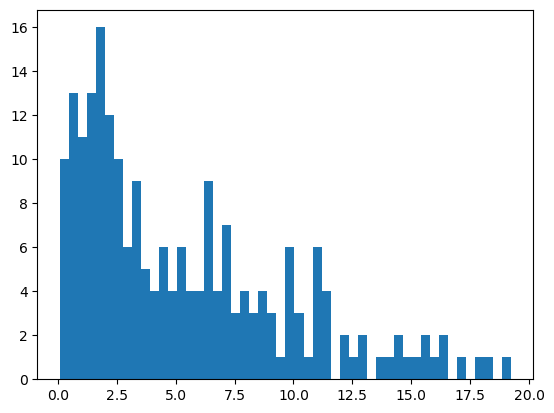

In [7]:
plt.hist(dfmain[(dfmain['area']>0)&(dfmain['area']<20)].area, bins=50)

plt.show()

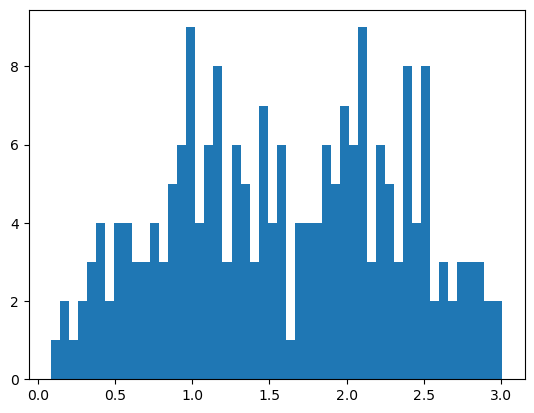

In [8]:
plt.hist(np.log(dfmain[(dfmain['area']>0)&(dfmain['area']<20)].area + 1), bins=50)

plt.show()

<BarContainer object of 12 artists>

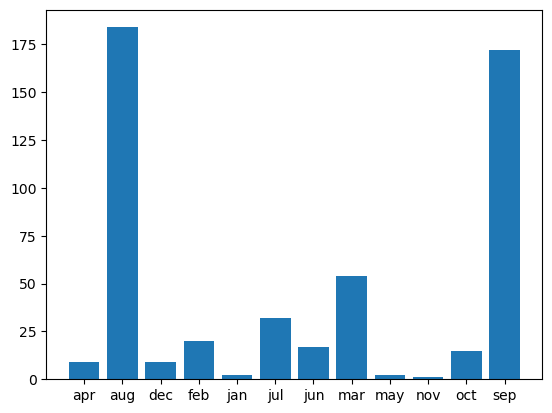

In [9]:
t = dfmain.groupby(['month'])['month'].count()
plt.bar(t.index, t)

In [10]:
dfmain.groupby(['month', 'fire_scale'])['fire_scale'].count()

month  fire_scale
apr    large_fire     4
       no_fire        5
aug    large_fire    71
       no_fire       85
       small_fire    28
dec    large_fire     9
feb    large_fire     9
       no_fire       10
       small_fire     1
jan    no_fire        2
jul    large_fire    12
       no_fire       14
       small_fire     6
jun    large_fire     5
       no_fire        9
       small_fire     3
mar    large_fire    16
       no_fire       35
       small_fire     3
may    large_fire     1
       no_fire        1
nov    no_fire        1
oct    large_fire     5
       no_fire       10
sep    large_fire    76
       no_fire       75
       small_fire    21
Name: fire_scale, dtype: int64

<BarContainer object of 7 artists>

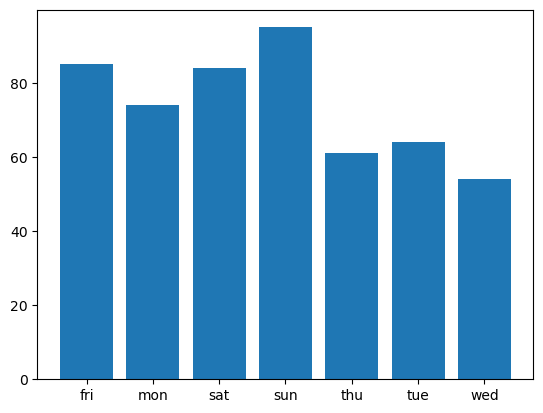

In [11]:
t = dfmain.groupby(['day'])['day'].count()
plt.bar(t.index, t)

# PART I

In [13]:
#d = dfmain.copy()
d = dfmain[dfmain['area']>0].copy()

In [14]:
print(d.shape)
for m in d['month'].unique():
    if((m!='aug')&(m!='sep')):
        temp = d[d['month']==m].sample(300, replace=True)
        d = pd.concat([d, temp], axis=0)

print(d.shape)



(270, 14)
(2670, 14)


<BarContainer object of 10 artists>

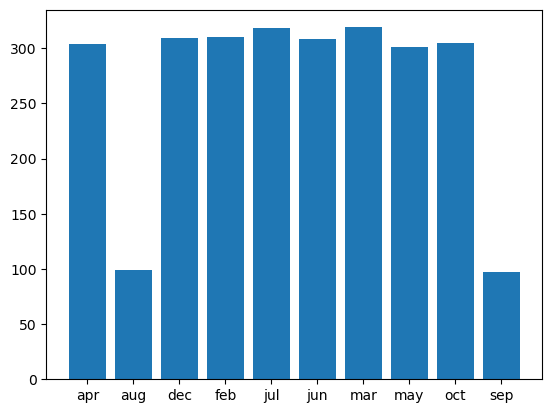

In [15]:
# plot
t = d.groupby(['month'])['month'].count()
plt.bar(t.index, t)

## Classification

In [17]:
dfc = dfmain.copy()

In [18]:
dfc.fire_scale.value_counts()

fire_scale
no_fire       247
large_fire    208
small_fire     62
Name: count, dtype: int64

In [19]:
print(dfc.shape)
for m in dfc['month'].unique():
    if((m!='aug')&(m!='sep')):
        temp = dfc[dfc['month']==m].sample(300, replace=True)
        dfc = pd.concat([dfc, temp], axis=0)

print(dfc.shape)


(517, 14)
(3517, 14)


### Convert to 1's and 0's

In [21]:
#d = dfmain[dfmain['area']>0].copy()

In [22]:
Xc = dfc.drop(['area', 'fire_scale'], axis=1)
yc = dfc['fire_scale']

In [23]:
Xc = pd.get_dummies(Xc, ['month', 'day'])
Xc.head(2)

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,False,False,False,True,False,False,False,False,False,False
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,False,True,False,False,False,False,False,False,True,False


In [24]:
x_cols_for_scaling = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

### Check

In [26]:
# Zero var
print(Xc.shape)
Xc = Xc[Xc.columns[(Xc.var(axis=0)>0).values]]
print(Xc.shape)

(3517, 29)
(3517, 29)


In [27]:
# Collinearity
print(Xc.shape)
x_corr = Xc.corr()**2

x_upper = x_corr.where(np.triu(np.ones(x_corr.shape), k=1).astype(np.bool))

# r2>0.7
drop_col = [col for col in x_upper.columns if any(x_upper[col] > 0.70)]

Xc = Xc.drop(drop_col, axis=1)
print(Xc.shape)

(3517, 29)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3696\3602340035.py:5: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  x_upper = x_corr.where(np.triu(np.ones(x_corr.shape), k=1).astype(np.bool))


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

### Split



In [28]:
x_train, x_test, y_train, y_test = train_test_split(Xc, yc, 
                                                    shuffle=True, stratify=yc)
print(x_train.shape, x_test.shape)

(2637, 29) (880, 29)


#### Split for scaling

In [31]:
x_train_orig = x_train.loc[:, x_cols_for_scaling]
x_train_cat = x_train.drop(x_cols_for_scaling, axis=1)

x_test_orig = x_test.loc[:, x_train_orig.columns]
x_test_cat = x_test.loc[:, x_train_cat.columns]

#### StandardScaler

In [34]:
scl=preprocessing.StandardScaler()
scl.fit(x_train_orig)

x_train_orig = scl.transform(x_train_orig)
x_test_orig = scl.transform(x_test_orig)

# Combine
x_train = np.concatenate([x_train_orig, np.array(x_train_cat)], axis=1)
x_test = np.concatenate([x_test_orig, np.array(x_test_cat)], axis=1)

print(x_train.shape, x_test.shape)

(2637, 29) (880, 29)


### Model 1: Logistic Regression

In [51]:
clf = linear_model.LogisticRegression(max_iter=int(1e7), penalty='elasticnet', solver='saga', l1_ratio=0.75)

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

acu = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: ", np.round(acu, 4))

Accuracy:  0.7591


### Model 2: SVM

In [53]:
clf = svm.SVC(C=1, kernel='rbf', gamma='auto', max_iter=int(5e4), cache_size=1000)

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

acu = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: ", np.round(acu, 4))

Accuracy:  0.8614


### Model 3: Random Forest Classfier

In [43]:
rfg = RandomForestClassifier(random_state=0)
rfg.fit(x_train, y_train)

y_pred_train = rfg.predict(x_train)
y_pred_test = rfg.predict(x_test)

train_acu = accuracy_score(y_pred_train, y_train)
print("Train Acccuracy: ", np.round(train_acu, 4))

test_acu = accuracy_score(y_pred_test, y_test)
print("Test Accuracy: ", np.round(test_acu, 4))

Train Acccuracy:  0.9954
Test Accuracy:  0.9375


### Model 4: Adaboost Classifier

In [46]:
from sklearn.ensemble import AdaBoostClassifier

rfg = RandomForestClassifier(random_state=0)
rfg.fit(x_train, y_train)

y_pred_train = rfg.predict(x_train)
y_pred_test = rfg.predict(x_test)

train_acu = accuracy_score(y_pred_train, y_train)
print("Train Acccuracy: ", np.round(train_acu, 4))

test_acu = accuracy_score(y_pred_test, y_test)
print("Test Accuracy: ", np.round(test_acu, 4))

Train Acccuracy:  0.9954
Test Accuracy:  0.9375


### Model 5: Multilayer Perceptron

In [49]:
mlp=MLPClassifier(random_state=0)
mlp.fit(x_train, y_train)

y_pred_train = mlp.predict(x_train)
y_pred_test = mlp.predict(x_test)

train_acu = accuracy_score(y_pred_train, y_train)
print("Train Acccuracy: ", np.round(train_acu, 3))

test_acu = accuracy_score(y_pred_test, y_test)
print("Test Accuracy: ", np.round(test_acu, 3))

Train Acccuracy:  0.981
Test Accuracy:  0.94


C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Thus, we obtain an accuracy about 98%. Let us now save the model for deployment purpose.

In [ ]:
# Saving the standard scaler
# joblib.dump(scl, 'scaler.pkl')

print("Scaler saved successfully.")

In [ ]:
# joblib.dump(mlp, 'forest_fire_model.joblib')

print("Model saved successfully.")